# Using MobileNetV3 to classify input image into 2 wheeler/4 wheeler/No Wheeler(Invalid)


In [3]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data Setup


In [5]:
# DIRECTORY INFORMATION
from pathlib import Path
from helper_functions import walk_through_dir

path = "data/vehicle_classifier_3Output/labels"

image_path = Path(path)
# two_wheel_image_path_list = list(image_path.glob("1_two wheeler/*.jpg"))
# four_wheel_image_path_list = list(image_path.glob("2_four wheeler/*.jpg"))
# no_wheel_image_path_list = list(image_path.glob("0_no wheeler/*.jpg"))
image_path_list = list(image_path.glob("*/*.jpg"))

walk_through_dir(path)

There are 3 directories and 0 images in 'data/vehicle_classifier_3Output/labels'.
There are 0 directories and 500 images in 'data/vehicle_classifier_3Output/labels\0_no wheeler'.
There are 0 directories and 500 images in 'data/vehicle_classifier_3Output/labels\1_two wheeler'.
There are 0 directories and 500 images in 'data/vehicle_classifier_3Output/labels\2_four wheeler'.


### 1.1 Downloading Weights of MobileNet and checking Transformations


In [6]:
from torchvision import models

manual_transform = v2.Compose(  # auto transform performs better
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        # v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3]),
        # v2.InterpolationMode.BILINEAR,
    ]
)
weights = models.MobileNet_V3_Large_Weights.DEFAULT
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [2]:
# VISUALIZING TRANSFORMED IMAGES
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list, auto_transform, 3, seed=5)

NameError: name 'image_path_list' is not defined

### 1.2 Setting up data features/labels and loaders


In [20]:
# from torch.utils.data import Subset

data = datasets.ImageFolder(root=image_path, transform=auto_transform)
class_names = data.classes

# two_wheelers = Subset(data, indices=range(1000, 1500))
# four_wheelers = Subset(data, indices=range(1500, 2000))
print(f"Class dictionary: {data.class_to_idx},\nLength: {len(data)}")

Class dictionary: {'0_no wheeler': 0, '1_two wheeler': 1, '2_four wheeler': 2},
Length: 1500


In [8]:
import torch
from PIL import Image

img = Image.open("check.jpg")
img_tensor = auto_transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

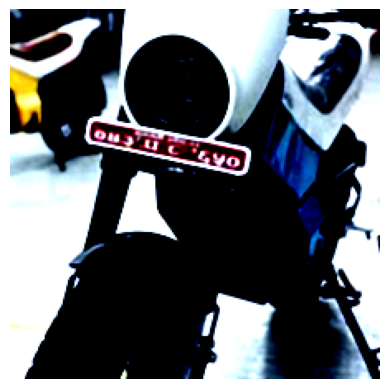

In [9]:
plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis(False)

### 1.3 SPLITTING THE DATA ARRAY INDICES INTO TRAIN AND TEST

- 0-499 "No Wheelers", so taking 0-400 in train and 400-500 in test


In [23]:
train_indices = (
    [i for i in range(0, 400)]
    + [i for i in range(500, 900)]
    + [i for i in range(1000, 1400)]
)

test_indices = (
    [i for i in range(400, 500)]
    + [i for i in range(900, 1000)]
    + [i for i in range(1400, 1500)]
)

In [24]:
from torch.utils.data import Subset

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)
len(train_data), len(test_data)

(1200, 300)

In [25]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed(42)
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x241a3ac6a80>,
 <torch.utils.data.dataloader.DataLoader at 0x241a91ca6f0>)

### 1.4 Visualizing random images from the data loader


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label: 1_two wheeler


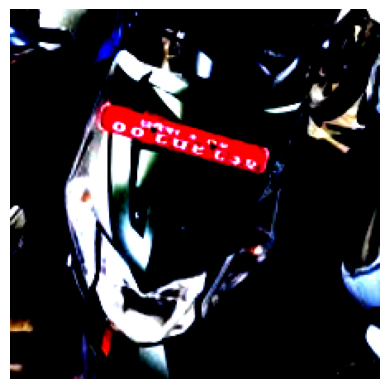

In [26]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {class_names[label]}")
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.show()

## 2. Instantiating Model from torchvision.models


In [27]:
from torchvision import models

weightsv3 = models.MobileNet_V3_Large_Weights.DEFAULT
modelv3 = models.mobilenet_v3_large(weights=weightsv3).to(device)

### 2.1 Info for model


In [67]:
from torchinfo import summary

summary(
    modelv3,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 

### 2.2 Freezing layers and re-defining the last layer


In [29]:
for param in modelv3.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
modelv3.classifier = nn.Sequential(
    nn.Linear(
        in_features=960,
        out_features=1280,
        bias=True,
    ),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)

#      Modelv3 Classifier Layer
#     (0)Linear(in_features=960, out_features=1280, bias=True)
#     (1): Hardswish()
#     (2): Dropout(p=0.2, inplace=True)
#     (3): Linear(in_features=1280, out_features=1000, bias=True)

## 3.Training Time


In [30]:
loss_fn_large = nn.CrossEntropyLoss()
optimizer_large = torch.optim.AdamW(modelv3.parameters())
# optimizer_large = torch.optim.SGD(modelv3.parameters(), lr=0.005, momentum=0.9)

In [31]:
import engine  # contains our training functions

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results_v3large = engine.train(
    model=modelv3,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer_large,
    loss_fn=loss_fn_large,
    epochs=20,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1717 | train_acc: 0.9482 | test_loss: 0.2537 | test_acc: 0.9094
Epoch: 2 | train_loss: 0.0382 | train_acc: 0.9852 | test_loss: 0.0416 | test_acc: 0.9781
Epoch: 3 | train_loss: 0.0144 | train_acc: 0.9975 | test_loss: 0.0327 | test_acc: 0.9906
Epoch: 4 | train_loss: 0.0105 | train_acc: 0.9951 | test_loss: 0.0237 | test_acc: 0.9906
Epoch: 5 | train_loss: 0.0162 | train_acc: 0.9975 | test_loss: 0.0109 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0047 | train_acc: 0.9992 | test_loss: 0.0211 | test_acc: 0.9906
Epoch: 7 | train_loss: 0.0410 | train_acc: 0.9910 | test_loss: 0.0268 | test_acc: 0.9906
Epoch: 8 | train_loss: 0.0041 | train_acc: 0.9992 | test_loss: 0.0221 | test_acc: 0.9906
Epoch: 9 | train_loss: 0.0147 | train_acc: 0.9959 | test_loss: 0.0148 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0048 | train_acc: 0.9992 | test_loss: 0.0123 | test_acc: 0.9969
Epoch: 11 | train_loss: 0.0009 | train_acc: 1.0000 | test_loss: 0.0128 | test_acc: 0.9969
Epoch: 12 | train_l

# _ Checkpoint - Saving/Loading Model _


In [376]:
from utils import save_model

save_model(modelv3, "data/saved_models", "modelv3_3OP.pth")

[INFO] Saving model to: data\saved_models\modelv3_3OP_augmented.pth


In [1]:
# Importing libraries
import torch
from torch import nn
from torchvision import models
from torchvision import datasets
from torchvision.transforms import v2
from pathlib import Path

# Set the manual seeds and device
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"


# Instantiate model and transform parameters
weightsv3 = models.MobileNet_V3_Large_Weights.DEFAULT
modelv3 = models.mobilenet_v3_large(weights=weightsv3).to(device)
auto_transform = weightsv3.transforms()

# Load directory path for classnames
path = "data/vehicle_classifier_3Output/labels"
image_path = Path(path)
data = datasets.ImageFolder(root=image_path, transform=auto_transform)
class_names = data.classes

# Freezing the final classifier layer
for param in modelv3.features.parameters():
    param.requires_grad = False

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
modelv3.classifier = nn.Sequential(
    nn.Linear(
        in_features=960,
        out_features=1280,
        bias=True,
    ),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)

modelv3.load_state_dict(torch.load("data/saved_models/modelv3_3OP.pth"))

<All keys matched successfully>

# 4. Visualizing the Results


In [2]:
# only works if test loop executed
from helper_functions import plot_loss_curves


plot_loss_curves(results_v3large)

NameError: name 'results_v3large' is not defined

In [3]:
from torch.utils.data import DataLoader

# Loading unseen data from directory


new_dir = "data/unseen"


unseen_dataset = datasets.ImageFolder(new_dir, transform=auto_transform)


unseen_loader = DataLoader(
    unseen_dataset,
    shuffle=False,
)


# Get samples and labels from the unseen data in different lists


test_samples = []


test_labels = []


for sample, label in unseen_loader:

    test_samples.append(sample)

    test_labels.append(label.item())


print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]


In [4]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)  # Add an extra dimension for batch

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # Perform softmax on the channel dimension

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.cat(pred_probs, dim=0)


pred_probs = make_predictions(model=modelv3, data=test_samples)
# Converting prediction probabilities into labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2])

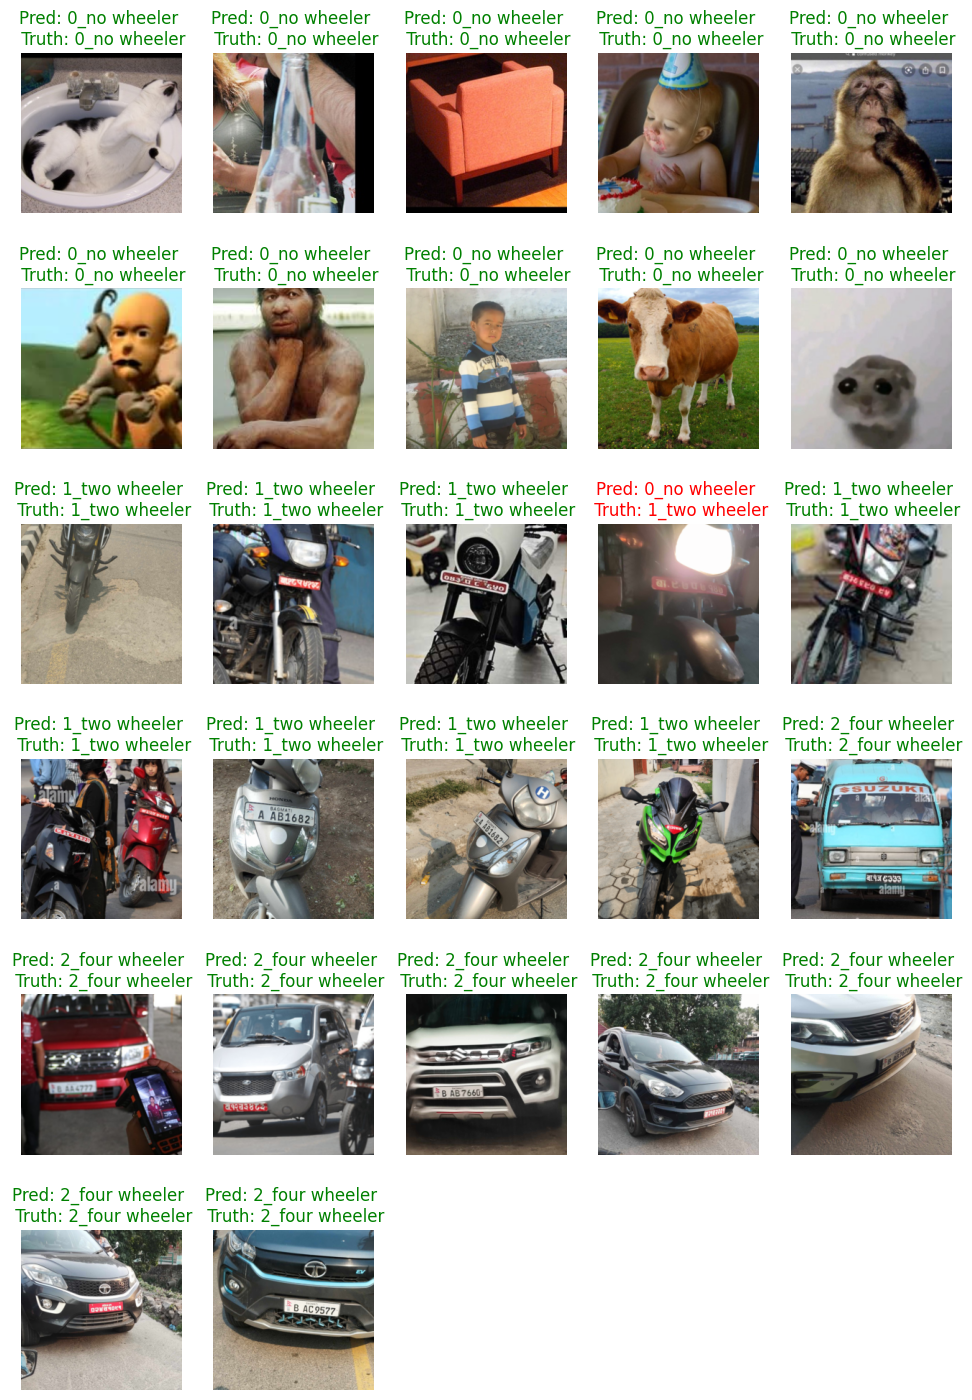

In [16]:
from matplotlib import pyplot as plt

# Plot predictions

inv_normalize = v2.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)
num_images = len(test_samples)

nrows = num_images // 3

ncols = 5

figsize = (12, num_images)

plt.figure(figsize=figsize)

for i, sample in enumerate(test_samples):

    # Create a subplot

    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image

    sample = sample.squeeze()

    plt.title("SCORE: {accuracy}%")

    plt.imshow(inv_normalize(sample).permute(1, 2, 0))

    # Find the prediction label (in text form, e.g. "Sandal")

    pred_label = class_names[pred_labels[i].item()]

    truth_label = class_names[test_labels[i]]

    # Get the confidence score for the prediction from pred_probs

    confidence = torch.max(pred_probs[i]).item()

    # Create the title text of the plot

    title_text = f"Pred: {pred_label} \n Truth: {truth_label}"

    # Check for equality and change title colour accordingly

    if pred_label == truth_label:

        plt.title(title_text, fontsize=12, c="g")  # green text if correct

    else:

        plt.title(title_text, fontsize=12, c="r")  # red text if wrong

    plt.axis(False)

In [32]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
modelv3.eval()
with torch.inference_mode():
    for X, y in tqdm(test_loader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = modelv3(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(
            dim=1
        )  # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelv3.eval()  # Set the model to evaluation mode
labels = []
for _, y in test_loader:
    labels.extend(y.numpy())

# Convert the list to a PyTorch tensor
labels_tensor = torch.tensor(labels)
labels_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

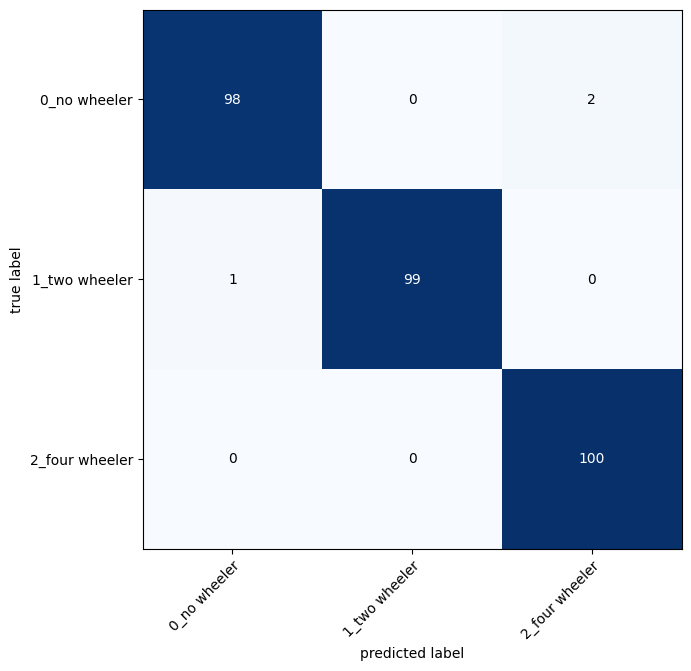

In [54]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
targets = []
for X, y in test_loader:
    targets.append(y)

confmat_tensor = confmat(preds=y_pred_tensor, target=labels_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=class_names,  # turn the row and column labels into class names
    figsize=(10, 7),
)